In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from matplotlib import pyplot as plt 

In [2]:
def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = np.ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data:
        print('Mensaje', index, ':', data[index])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

Aquí se encuentras las variables que se utulizan a lo largo de todo el código.

Modificar aquí los valores para probar distintas configuraciones

In [3]:
seed = 2020

numMuestras = 3

#Niveles de exhaustividad a calcular
niveles = [3,10]

In [4]:
train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test')

print("Training texts:", len(train_data.data))
print("Test texts:", len(test_data.data))

Training texts: 11314
Test texts: 7532


In [5]:
# Pasamos el fichero a una lista (una línea por item)
with open('words.txt') as f:
    dictionary = f.read().splitlines()

In [6]:
#vectorizer = CountVectorizer(binary= False, vocabulary=dictionary, stop_words='english', ngram_range = (1,1))

In [7]:
#train_vector_data = vectorizer.fit_transform(train_data.data)
#test_vector_data = vectorizer.fit_transform(test_data.data)

Procedemos a elegir 3 mensajes de cada tipo

In [8]:
vectorizer = CountVectorizer(binary= False, vocabulary=dictionary, stop_words='english', ngram_range = (1,1))

trainVectorData = vectorizer.fit_transform(train_data.data)
testVectorData = vectorizer.fit_transform(test_data.data)

tfidfer = TfidfTransformer()
trainTF = tfidfer.fit_transform(trainVectorData)
testTF = tfidfer.fit_transform(testVectorData)

In [9]:
feature_names = vectorizer.get_feature_names()

In [10]:
write_terms(feature_names, None, trainVectorData, 1)

Mensaje 1 vectorizado: ['acceleration' 'adapters' 'answered' 'article' 'attained' 'brave' 'cards'
 'clock' 'days' 'detailing' 'disk' 'especially' 'experiences' 'final'
 'floppy' 'floppies' 'functionality' 'heat' 'hour' 'keywords' 'knowledge'
 'lines' 'message' 'network' 'number' 'organization' 'oscillator'
 'posting' 'procedure' 'rated' 'reports' 'requested' 'send' 'shared'
 'sinks' 'souls' 'speed' 'subject' 'summary' 'summarizing' 'thanks'
 'upgrade' 'upgraded' 'usage'] 



In [11]:
#cambia la forma de un array a otro de 2 dimensiones
def reshape2D(array, filas, columnas):
    
    nuevaForma = np.reshape(array, [filas,columnas])
    return nuevaForma

In [34]:
#while the last element of the sum of all the previous elements (which is the sum of the total selectec texts) 
#    is less than the desired amount, it will keep choosing candidates

def selectIndexes(numMuestras, clases, seed=2020):

    random.seed(seed)
    
    selected = np.zeros(len(clases))
    selected_index = np.zeros(len(test_data.target_names)*numMuestras)
        
    while (np.cumsum(selected)[-1] < len(selected)*numMuestras):

        #Indice aleatorio de la lista de mensajes
        index = random.randint(0, len(test_data.target) - 1)
        #cat = numero de la categoria a la que pertenece el índice elegido
        cat = test_data.target[index]
        #Comprobamos que no haya ya 3 elementos de la categoría a la que pertenezca el index y lo añadimos a la cuenta y a la lista de índices
        #La lista de índices estará ordenada por categorías
        if(selected[cat] < 3):
            index_pos = int(cat*numMuestras + selected[cat])
            selected_index[index_pos] = index
            selected[cat] += 1
        
    nuevaForma = reshape2D(selected_index, len(clases), numMuestras)
    return nuevaForma

Igual merece más la pena ponerlo en una matriz de N*M siendo N el número de elementos por cada clase y M el número de clases

In [13]:
ind = selectIndexes(3, test_data.target_names)

Hacer un ejemplo de cosine similaroty

In [14]:
def sortSimilarityIndex(cosSim):
    
    for i, category in enumerate(cosSim):
        for j, sim in enumerate(category):
            cosSim[i][j] = np.argsort(-sim)
    return cosSim

In [15]:
def cosSim_calc(indexes, test_vector, train_vector):
    cosSim = np.zeros(indexes.shape, object)
    for i, indexList in enumerate(indexes):
        for j, index in enumerate(indexList):
            cosSim[i][j] = cosine_similarity(test_vector[index], train_vector)[0]
    return cosSim

In [16]:
cos_sim = cosSim_calc(ind,testVectorData, trainVectorData)
cos = sortSimilarityIndex(cos_sim)

Ahora toca hacer los niveles de exhaustividad con la información bien colocadita que tenemos aquí

Lo que vamos a hacer es dejar en una matriz de N*M los resultados del recall
    Siendo N=número de clases y M=niveles de exhaustividad

In [17]:
def nivelesExhaustividad(data, niveles):
    #exhaustN = np.zeros(data.shape, object)
    exhaust = []
    
    for nivel in niveles:
        exhaustN = np.zeros(data.shape, object)
        for i, indexList in enumerate(data):
            for j, index in enumerate(indexList):
                exhaustN[i][j] = data[i][j][:nivel:1]
        exhaust.append(exhaustN)
        
        exhaustNP = np.array(exhaust)
        
    return exhaustNP

In [18]:
exhaustIndex = nivelesExhaustividad(cos, niveles)

In [19]:
def calcPrecision(exhaustIndex, train_data):
    precision = np.zeros(exhaustIndex.shape, object)
    
    for i, nivel in enumerate(exhaustIndex):
        for j, indexList in enumerate(nivel):
            for k, BestIndexes in enumerate(indexList):
                prec = 0
                for index in BestIndexes:
                    #Si el indice del train data coincide con la j, es bueno
                    if(train_data[index] == j):
                        prec += 1
                prec /= len(BestIndexes)
                
                precision[i][j][k] = prec
                
    return precision

In [20]:
precision = calcPrecision(exhaustIndex, train_data.target)

In [28]:
def precMedia(precisiones):
    precMedia = np.zeros(precisiones.shape, object)
    # Ahora reducimos una dimansión, porque al hacer la media los "num_samples" de valores se reducirán a solo 1
    precMedia = precMedia[:, :, 0]

    for i, nivel in enumerate(precisiones):
        for j, clase in enumerate(nivel):
            precMedia[i][j] = clase.mean()
            
    return precMedia

In [22]:
precMedia = precMedia(precision)

In [23]:
def imprimirGraficas(info, niveles, clases):
    fig, ax = plt.subplots()
        
    ax.set_xticks(np.arange(len(clases)))
    ax.set_xticklabels(clases)

    ylabel = np.arange(0.0, 1.0, 0.1)
    ax.set_yticks(ylabel)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    ax.set_title("Precisión media con diferentes niveles de exhaustividad")
    fig.set_size_inches(14,8)
    fig.tight_layout()
    
    for i, nivel in enumerate(info):
        ax.plot(clases, nivel, label = "Nivel exhaustividad " + str(niveles[i]))
    
    plt.legend(framealpha=1, frameon=True);
    
    plt.show()

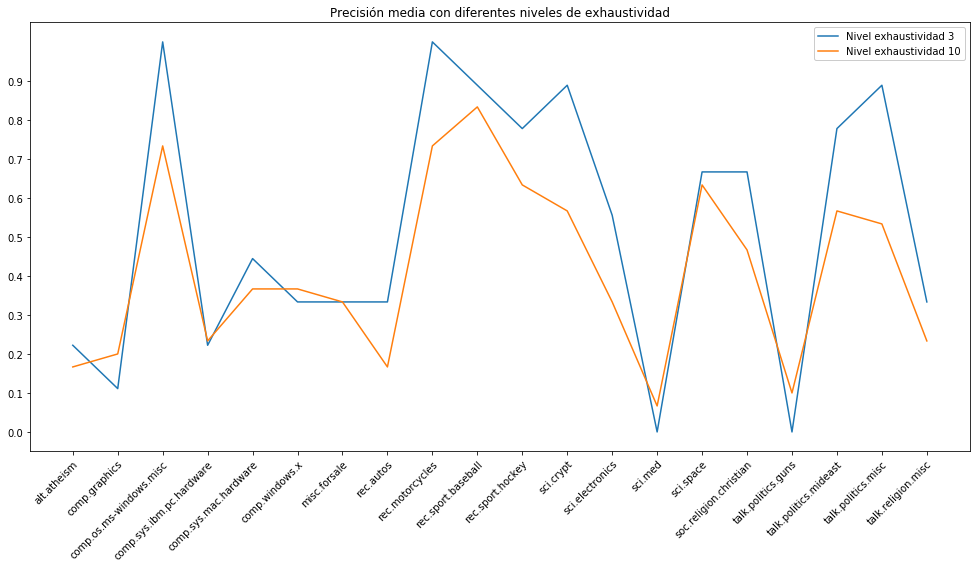

In [24]:
imprimirGraficas(precMedia, niveles, train_data.target_names)

In [30]:
def allInOne(trainVecData, testVecData):
    
    indices = selectIndexes(numMuestras, test_data.target_names)
    
    cosineSimilarity = cosSim_calc(indices,testVecData, trainVecData)
    cosine = sortSimilarityIndex(cosineSimilarity)
    
    
    exhaustividadIndex = nivelesExhaustividad(cosine, niveles)
    
    precisionClases = calcPrecision(exhaustividadIndex, train_data.target)
    
    precisionMedia = precMedia(precisionClases)
    
    imprimirGraficas(precisionMedia, niveles, train_data.target_names)

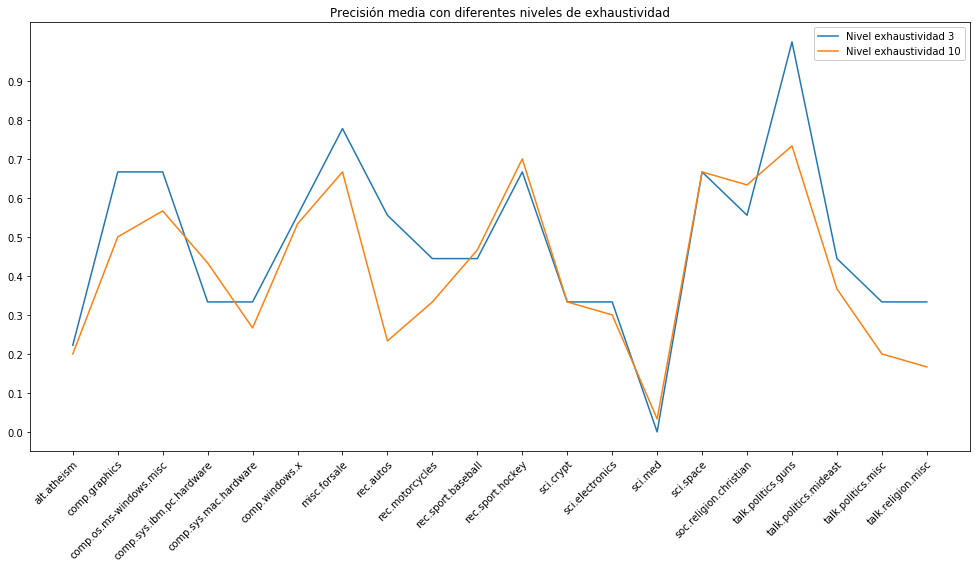

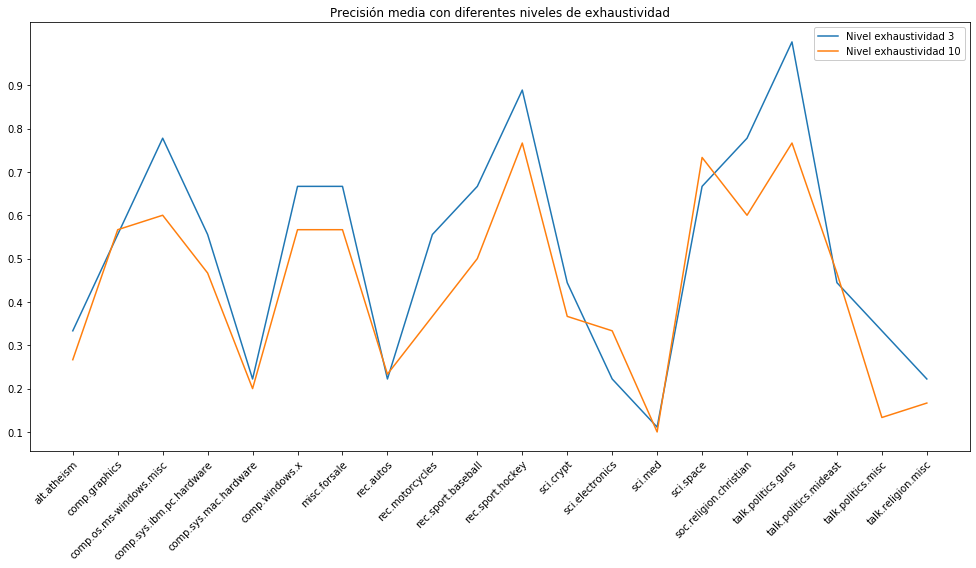

In [35]:
allInOne(trainVectorData, testVectorData)
allInOne(trainTF, testVectorData)